# Preliminary Notes and Vocab

* ReLU (rectified linear unit), sets all negative values to zero
* Logits - "raw" output of a model: [-0.5903, -1.9432,  1.1363, -0.7191, ...]
* Sigmoid - Predictions based on the logits: [0.7432, 0.3417, 0.1343, 0.1795, ...], required for binary classification
* softmax - Predictions based on the logits, but required for multiclass classification
* argmax, argmins - returns index of max/min values: [5, 1, 3, 4, 2, ...]
* torch.round - to get 0 or 1 (binary classification) from Sigmoid
* hidden units, neurons - amount of features between the layers

### Additional resources
* https://www.learnpytorch.io/02_pytorch_classification/#0-architecture-of-a-classification-neural-network


# Dependencies

In [3]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm

print(f"Torch version: {torch.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"

device = "mps" if torch.backends.mps.is_available() else device

print(f"Using device: {device}")

random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

Torch version: 2.1.2
Using device: mps


/Users/nicky.reinert/development.private/python/modelling/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Fake Data

,X1,X2,y
0,0.754246,0.231481,1.0
1,-0.756159,0.153259,1.0
2,-0.815392,0.173282,1.0
3,-0.393731,0.692883,1.0
4,0.442208,-0.896723,0.0


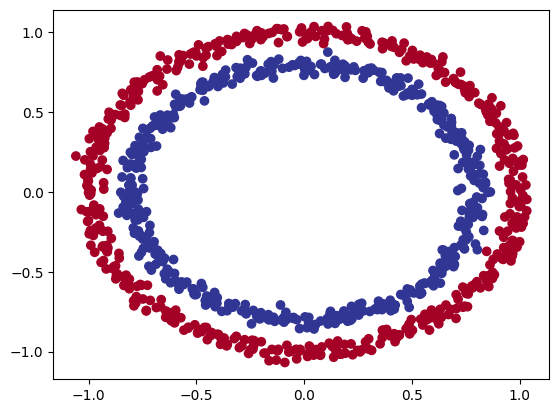

In [4]:
n_samples=1000

X, y = make_circles(
    n_samples=n_samples,
    noise=0.03,
    random_state=42
    )

# to tensor data type
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

circles = pd.DataFrame({
    "X1" : X[:, 0],
    "X2" : X[:, 1],
    "y": y
})

plt.scatter(
    x=circles["X1"],
    y=circles["X2"],
    c=circles["y"],
    cmap=plt.cm.RdYlBu
)
circles.head(5)


# Prepare

In [5]:
epochs = 1000

learning_rate = 0.1

epoch_count = []
loss_values = []
acc_values = []
test_loss_values = []
test_acc_values = []

# Functions

In [6]:

class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function

    def forward(self, x):
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
        
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def plot_loss_and_accuracy(
    axis,
    fig,
    epoch_count,
    loss_values,
    test_loss_values,
    acc_values, 
    test_acc_values
  ):


    loss_values = np.array(torch.tensor(loss_values).cpu().numpy())
    test_loss_values = np.array(torch.tensor(test_loss_values).cpu().numpy())

    # plt.figure(figsize = (10, 7))

    axis.plot(epoch_count, loss_values, label = "train loss", color="tab:red")
    axis.plot(epoch_count, test_loss_values, label = "test loss", color="tab:red", linestyle="dashed")
    # axis.axis(ymin=0,ymax=1)
    axis.set_ylabel('loss')
    axis.legend(loc="upper left")

    axis2 = axis.twinx()

    axis2.plot(epoch_count, acc_values, label = "train accuracy", color="tab:blue")
    axis2.plot(epoch_count, test_acc_values, label = "test accuracy", color="tab:blue", linestyle="dashed")
    # axis2.axis(ymin=0,ymax=100)
    axis2.set_ylabel('accuracy')
    axis2.legend(loc="upper right")

    # axis.title('training and test loss curves')
    fig.suptitle('loss and accuracy')

    axis.set_xlabel('epochs')

def plot_predictions(
    axis,
    fig,
    train_data,
    train_labels, 
    test_data, 
    test_labels,
    predictions):
  
    # plt.figure(figsize = (10, 7))
    

    plt.scatter(
        x=circles["X1"],
        y=circles["X2"],
        c=circles["y"],
        cmap=plt.cm.RdYlBu
    )
    axis.scatter(train_data, train_labels, c = "b", s = 1, label = "training data")

    axis.scatter(test_data, test_labels, c = "g", s = 20, label = "testing data")

    if predictions is not None:
        axis.scatter(test_data, predictions, c = "r", s = 10, label = "predictions")

    axis.legend(prop = {"size": 14})

# Run

In [7]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# INIT MODEL
# model_0 = CircleModel()

# or just
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=1)
)

# MOVE MODEL AND DATA TO ONE DEVICE
model_0.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# INIT LOSS FUNCTION
loss_fn = nn.BCEWithLogitsLoss()

# INIT OPTIMIZER
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=learning_rate)

In [14]:
start_epoch = 0 if len(epoch_count) == 0 else epoch_count[-1]

for epoch in tqdm(range(start_epoch, start_epoch + epochs)):
    
    # TRAIN MODE ON
    model_0.train()

    # CALC PREDICTIONS
    # logit -> sigmoid, softmax (binary, multiclass)
    y_logits = model_0(X_train).squeeze()
    y_preds_probabilities = torch.sigmoid(y_logits) # sigmoid for binary classificatioN!
    y_preds = torch.round(y_preds_probabilities)

    # CALC LOSS
    loss = loss_fn(y_logits,
                   y_train)

    # CALC ACCURACY
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_preds)

    # SET OPTIMIZER TO ZERO
    optimizer.zero_grad()

    # BACK PROPAGATION
    loss.backward()

    # UPDATE PARAMETERS
    optimizer.step()

    # EVAL MODE ON
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze() 
        test_preds_probabilities = torch.sigmoid(test_logits) # sigmoid for binary classification!
        test_preds = torch.round(test_preds_probabilities)
        
        test_loss = loss_fn(test_logits, 
                            y_test)

        test_acc = accuracy_fn(y_true=y_test,
                      y_pred=test_preds)

    # VISULIZE
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    acc_values.append(acc)
    test_acc_values.append(test_acc)

    # LOG
    if epoch % int(epochs / 10) == 0:
        print(f"Epoch {epoch} | Loss {loss:.2f} | Test Loss {test_loss:.2f} | Acc {acc:.2f} | Test Acc {test_acc:.2f}")


  4%|▍         | 38/1000 [00:00<00:05, 189.49it/s]

Epoch 1000 | Loss 0.26 | Test Loss 0.30 | Acc 99.88 | Test Acc 100.00


 14%|█▎        | 137/1000 [00:00<00:03, 240.17it/s]

Epoch 1100 | Loss 0.23 | Test Loss 0.28 | Acc 99.88 | Test Acc 100.00


 23%|██▎       | 234/1000 [00:01<00:03, 232.44it/s]

Epoch 1200 | Loss 0.21 | Test Loss 0.25 | Acc 99.88 | Test Acc 100.00


 33%|███▎      | 330/1000 [00:01<00:02, 227.63it/s]

Epoch 1300 | Loss 0.18 | Test Loss 0.23 | Acc 100.00 | Test Acc 100.00


 45%|████▍     | 449/1000 [00:01<00:02, 233.00it/s]

Epoch 1400 | Loss 0.17 | Test Loss 0.21 | Acc 100.00 | Test Acc 100.00


 55%|█████▌    | 550/1000 [00:02<00:01, 241.43it/s]

Epoch 1500 | Loss 0.15 | Test Loss 0.19 | Acc 100.00 | Test Acc 100.00


 65%|██████▌   | 650/1000 [00:02<00:01, 237.25it/s]

Epoch 1600 | Loss 0.14 | Test Loss 0.18 | Acc 100.00 | Test Acc 100.00


 73%|███████▎  | 730/1000 [00:03<00:01, 252.69it/s]

Epoch 1700 | Loss 0.12 | Test Loss 0.16 | Acc 100.00 | Test Acc 100.00


 83%|████████▎ | 834/1000 [00:03<00:00, 248.62it/s]

Epoch 1800 | Loss 0.11 | Test Loss 0.15 | Acc 100.00 | Test Acc 100.00


 94%|█████████▍| 939/1000 [00:03<00:00, 243.11it/s]

Epoch 1900 | Loss 0.10 | Test Loss 0.14 | Acc 100.00 | Test Acc 100.00


100%|██████████| 1000/1000 [00:04<00:00, 237.63it/s]


# Visualize

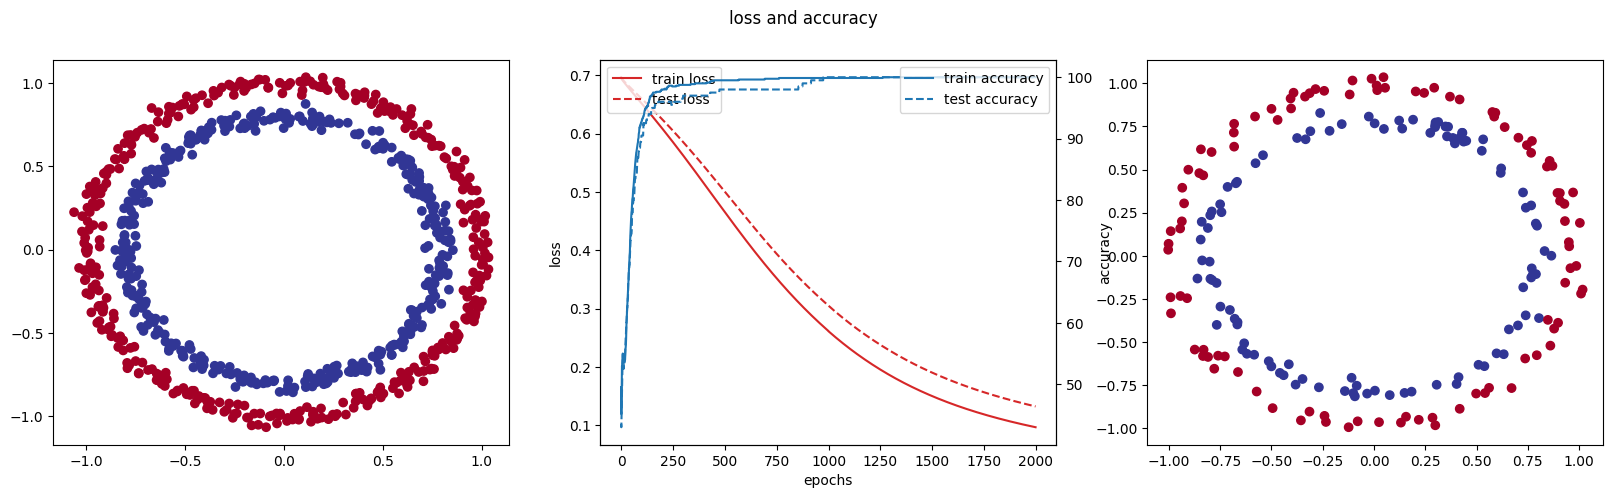

In [15]:
model_0.eval() 
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()

fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

axis[0].scatter(
    x=X_train[:, 0].cpu(),
    y=X_train[:, 1].cpu(),
    c=y_train.cpu(),
    cmap=plt.cm.RdYlBu
)

plot_loss_and_accuracy(axis = axis[1],
                        fig = fig,
                        epoch_count = epoch_count,
                        loss_values = loss_values,
                        test_loss_values = test_loss_values,
                        acc_values = acc_values,
                        test_acc_values = test_acc_values
                        )

axis[2].scatter(
    x=X_test[:, 0].cpu(),
    y=X_test[:, 1].cpu(),
    c=y_preds.cpu(),
    cmap=plt.cm.RdYlBu
)